## DeepShadows: Separating LSB galaxies from Artifacts using Deep Learning

**Author: Dimitrios Tanoglidis**

This notebook demonstrates an application of Convolutional Neural Networks (CCNs) in an astrophysics problem.

CNNs are inspired by the way the eye works and thus are very successful in Computer Vision tasks, pretty much with any task involving images.

Here we show how to write a simple CNN (DeepShadows) model, usind the Keras (https://github.com/keras-team/keras) library/framework, to classify images containing Low-Surface-Brightness-Galaxies (LSBGs) and (confusing) artifacts.
If you are more interested about the science, you can check our paper here: https://arxiv.org/abs/2011.12437


We will introduce and briefly explain the basic Deep Learning jargon.



### Import packages

It is a good practice to import the packages we are going to need at the beginning of the notebook/code

In [1]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
from scipy import interpolate
import random

# =========================================
# scikit-learn for Machine Learning - Here we use only the metrics

# Metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# =======================================
# Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# ==============================================
# ==============================================
# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

### Import datasets

Let's import the image datasets.

Now these are large, 30k for training, 5k for validation and 5k for testing.

Here, in order to speed up the process, we will keep a subset of these.

We need:

- `X_tr, X_val, X_test`: Refer to the training, validation and test sets for the image-based classification (deep learning).

- `y_tr, y_val, y_test`: Labels - training, validation and test sets.

In [2]:
# Mount drive to upload the datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# For image-based classification
X_tr = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_train.npy"))[:4000] #Training
X_val = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_val.npy"))[:500] #Validation
X_test = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_test.npy"))[:500] #Test

# Labels
y_tr = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_train.npy"))[:4000] # Training
y_val = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_val.npy"))[:500] #Validation
y_test = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_test.npy"))[:500] #Test

### Plot examples of LSBGs and Artifacts

It is always a good practice to check our dataset. Here we have images. If we had some numerical properties (features) we could make and inspect some histograms. Never apply fancy models before you get a sense of your data first.

In [4]:
X_pos = X_tr[y_tr==1.] #Positives - LSBGs
X_neg = X_tr[y_tr==0.] #Negatives - Artifacts

randind = np.random.randint(0,1000,20)

X_sample_LSBG = X_pos[randind]
X_sample_Artefacts = X_neg[randind]

- Plot examples of LSBGs


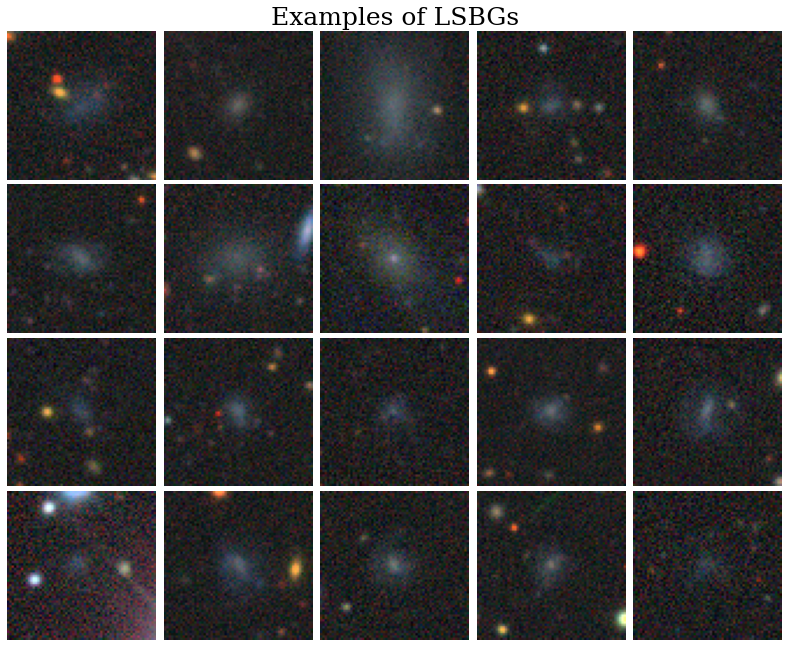

In [5]:
# Plot them
n_rows = 4
n_cols = 5

plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of LSBGs",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_sample_LSBG[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
plt.show()

- Plot examples of Artifacts

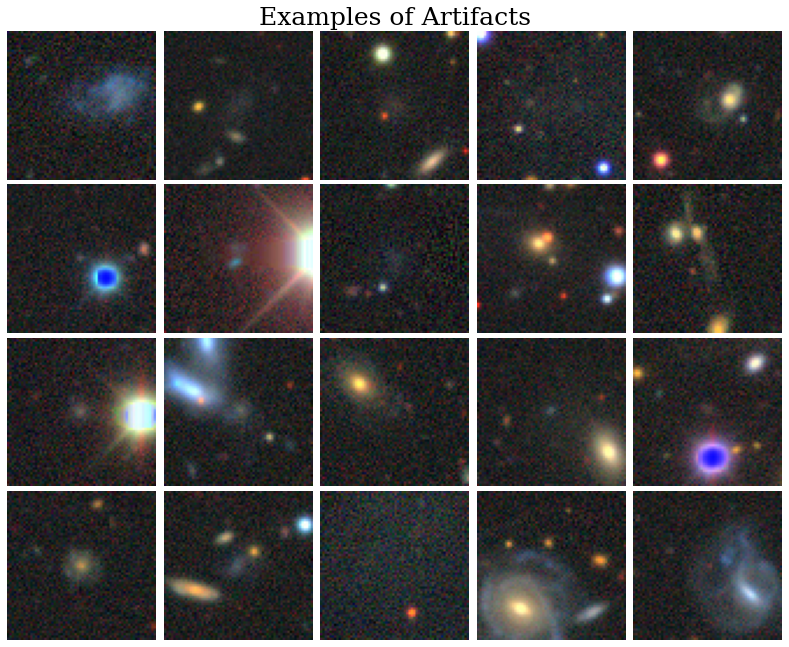

In [6]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of Artifacts",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_sample_Artefacts[i])
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)
plt.show()

## Build the *DeepShadows* model

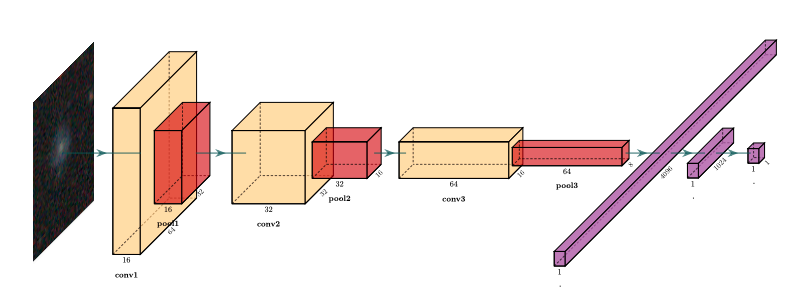

In [11]:
print(np.shape(X_tr))

(4000, 64, 64, 3)


In [7]:
# build the  original model
model = keras.models.Sequential()
model.add(InputLayer((64,64,3)))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(rate=0.4))
model.add(Conv2D(filters=2*16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(rate=0.4))
model.add(Conv2D(filters=2*32, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(rate=0.4))
model.add(Flatten())
model.add(Dense(units=1024, activation='relu',kernel_regularizer=regularizers.l2(0.12)))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer=optimizers.Adadelta(0.1),
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

In [8]:
n_epochs = 30 # Number of epochs


model.fit(x=X_tr, y=y_tr,
          epochs=n_epochs, batch_size=64,
          shuffle=True,
          validation_data=(X_val,y_val))

Epoch 1/30
63/63 [==============================] - 33s 17ms/step - loss: 0.8262 - accuracy: 0.7180 - val_loss: 0.6874 - val_accuracy: 0.4940
Epoch 2/30
63/63 [==============================] - 1s 11ms/step - loss: 0.4951 - accuracy: 0.8108 - val_loss: 0.7707 - val_accuracy: 0.4940
Epoch 3/30
63/63 [==============================] - 1s 10ms/step - loss: 0.4517 - accuracy: 0.8240 - val_loss: 0.6992 - val_accuracy: 0.5160
Epoch 4/30
63/63 [==============================] - 1s 10ms/step - loss: 0.4185 - accuracy: 0.8288 - val_loss: 0.6251 - val_accuracy: 0.6120
Epoch 5/30
63/63 [==============================] - 1s 10ms/step - loss: 0.3917 - accuracy: 0.8425 - val_loss: 0.8506 - val_accuracy: 0.6000
Epoch 6/30
63/63 [==============================] - 1s 10ms/step - loss: 0.3817 - accuracy: 0.8512 - val_loss: 0.5039 - val_accuracy: 0.7720
Epoch 7/30
63/63 [==============================] - 1s 10ms/step - loss: 0.3598 - accuracy: 0.8583 - val_loss: 0.4416 - val_accuracy: 0.8100
Epoch 8/30
6

### Evaluation

We can't go on without evaluating the performance of the model.

We start (always by printing the learning curves)

We always start by plotting the training history (Loss/Accuracy versus epoch)

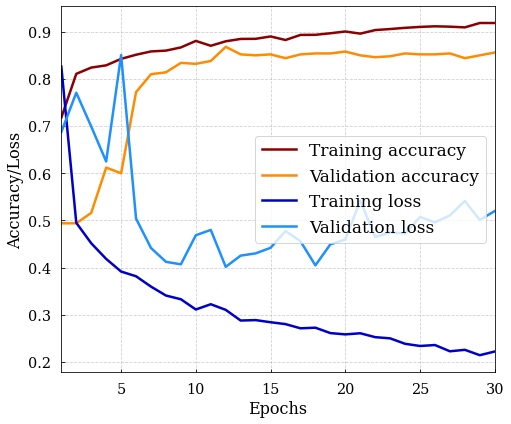

In [9]:
Epochs = np.arange(1,n_epochs+1,1)
history_dict = model.history.history

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_err = 1.0 - np.asarray(train_acc)
val_err = 1.0 - np.asarray(val_acc)

# =====================================================================
# =====================================================================
plt.figure(figsize=(7.2, 6.0))

# Plot Accuracy
plt.plot(Epochs, train_acc, c = 'darkred',linewidth=2.5,label='Training accuracy')
plt.plot(Epochs, val_acc , c = 'darkorange',linewidth=2.5,label='Validation accuracy')
# Plot Loss
plt.plot(Epochs, train_loss, c = 'mediumblue',linewidth=2.5,label='Training loss')
plt.plot(Epochs, val_loss , c = 'dodgerblue',linewidth=2.5,label='Validation loss')

# =====================================================================
plt.grid(ls='--',alpha=0.6)
plt.xlabel('Epochs', fontsize=16);plt.ylabel('Accuracy/Loss',fontsize=16)
plt.xlim(1,n_epochs)
#plt.ylim(0.2,1)
plt.legend(frameon=True, loc='center right', fontsize=17)
plt.tick_params(axis='both', labelsize=14.5)

plt.tight_layout()
plt.show()

**Print standard metrics**

- Precision = purity

- Recall = completeness

In [10]:
# Predict on test data 
y_pred_CNN = model.predict_classes(X_test)

# Print classification metrics 
print("Accuracy score for DL:",accuracy_score(y_test,y_pred_CNN))
print("Precision score for DL:",precision_score(y_test,y_pred_CNN))
print("Recall score for DL:",recall_score(y_test,y_pred_CNN))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy score for DL: 0.876
Precision score for DL: 0.8163934426229508
Recall score for DL: 0.9764705882352941


**Plot confusion matrix**

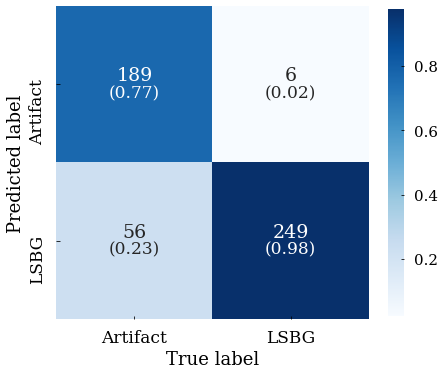

In [13]:
# Get the confusion matrix for the Deep Learning
con_mat_DL = confusion_matrix(y_test, y_pred_CNN)

# Get annotations and normalized confusion matrix
a = con_mat_DL[0]/np.sum(con_mat_DL[0])
b = con_mat_DL[1]/np.sum(con_mat_DL[1])


con_mat_normalized = np.zeros([2,2])
con_mat_normalized[0] = a
con_mat_normalized[1] = b

# Annotations
an_1 = "("+"{:.2f}".format(a[0])+")"
an_2 = "("+"{:.2f}".format(a[1])+")"
an_3 = "("+"{:.2f}".format(b[0])+")"
an_4 = "("+"{:.2f}".format(b[1])+")"

annots = np.zeros([2,2],dtype='U6')

annots[0,0] = an_1;annots[0,1] = an_2
annots[1,0] = an_3;annots[1,1] = an_4

class_names = ['Artifact','LSBG']
# ==============================================
# ==============================================


plt.figure(figsize = (7,6.0))
g =sns.heatmap(con_mat_DL.T, square = True, annot=True,annot_kws={'va':'bottom',"size": 19},fmt='.0f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)
sns.heatmap(con_mat_normalized.T, square=True, annot=annots.T, annot_kws={'va':'top',"size": 17},cmap='Blues',fmt='', cbar=True,
            cbar_kws={'shrink':0.94})
g.set_xticklabels(class_names, fontsize = 17)
g.set_yticklabels(class_names, fontsize = 17)

# Ticks for colorbar
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
# =========================================
# =========================================
plt.xlabel('True label',fontsize=18)
plt.ylabel('Predicted label',fontsize=18)
plt.show()

**Plot some examples**

In [25]:
pos_pred = X_test[y_pred_CNN[:,0]==1.]
neg_pred = X_test[y_pred_CNN[:,0]==0.]

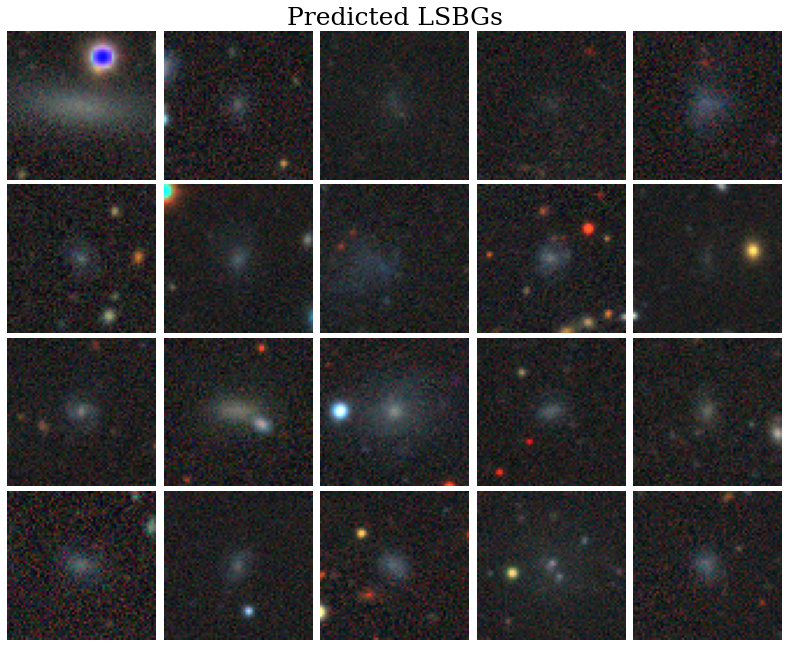

In [26]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Predicted LSBGs",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(pos_pred[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
plt.show()

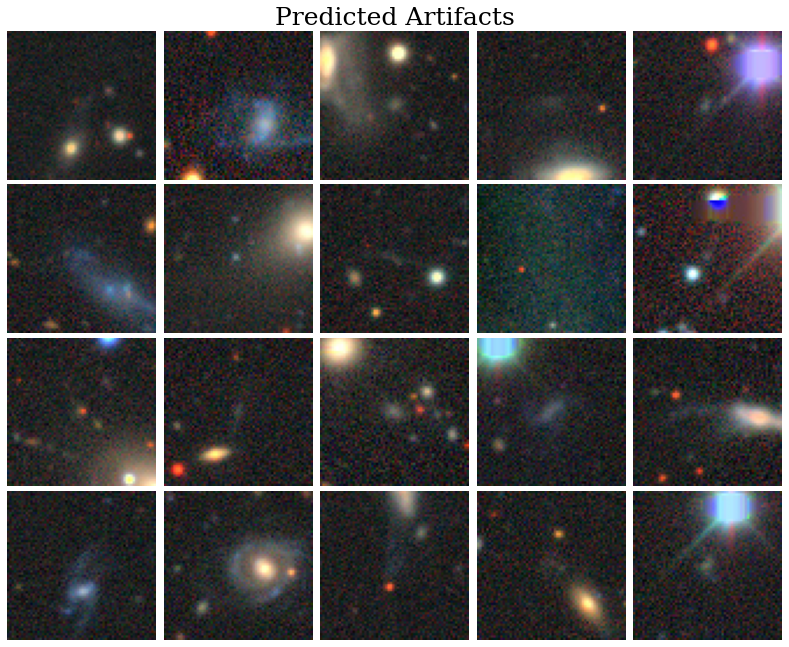

In [28]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))
for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Predicted Artifacts",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(neg_pred[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
plt.show()